## Simulating changes in the uncertainty of position and pattern signals

In response to reviewer comments we have run two additional auxiliary simulations, looking at the effect of changes in the uncertainty of incoming signals about the stimulus' position, and its internal pattern motion. 


In [1]:
## set up stable functions and parameters 

import numpy as np
import matplotlib.pyplot as plt
import warnings 

# suppress divide by zero warning which we can safely ignore. 
warnings.filterwarnings("ignore", category=RuntimeWarning)

def cart2pol(x, y):
    return np.sqrt(x**2 + y**2), np.arctan2(y, x)

# motion params taken from: https://jov.arvojournals.org/article.aspx?articleid=2765454
object_speed_x = 3.35
object_speed_y = -5.80
pattern_speed_x = -5.196
pattern_speed_y = -2.999

# specify sampling rate and time window (s)
sampling_rate = 500; # samples per second
delta = 1/sampling_rate # time step
time = 1.8 # time window of simulation
total_samples = time*sampling_rate

# slow speed priors 
alpha = 0.9 # object motion
beta = 0.5 # pattern motion 

# specify state error (SDs) 
# used to make the process noise covariance matrix (Q)
# and the state covariance matrix (P)
position_p = 1e-17 # assume change in position is essentially perfectly described by speed x time. 
object_speed_p = 0.9 # assuming slight uncertainty in change in object speed (e.g., from bouncing etc.)
pattern_speed_p = 0.9 # assume same for pattern speed


In [2]:
# define main simulation
# input can be set to 'position' or 'pattern' depending on which source of measurement noise 
# we want to modulate. 

def run_sim(manipulation):

    fig, ax = plt.subplots(3,3,figsize=(15,12), dpi = 300)

    for scale_ind, scaler in enumerate([0.5, 1, 2]): # scales for the noise parameter 

        # specify the measurement error (SDs)
        # used to make the measurement covariance matrix (R)
        # either position or pattern uncertainty are modulated
        position_sigma = 4*scaler if manipulation == 'position' else 4
        object_speed_sigma = 4
        pattern_speed_sigma = 4*scaler if manipulation == 'pattern' else 4

        # system matrix
        A = np.array([[1, delta, 0], [0, alpha, 0], [0, 0, beta]])
        A = np.block([[A, np.zeros_like(A)], [np.zeros_like(A), A]]) # make system matrix 2-D (x AND y)

        # observation matrix 
        H = np.array([[1, 0, 0], [0, 1, 0], [0, 1, 1]])
        H = np.block([[H, np.zeros_like(H)], [np.zeros_like(H), H]]) # make observation matrix 2-D

        # process noise covariance matrix
        Q = np.diag([position_p, object_speed_p, pattern_speed_p])**2
        Q = np.block([[Q, np.zeros_like(Q)], [np.zeros_like(Q), Q]]) # make process noise covariance matrix 2-D

        # measurement noise covariance matrix 
        R = np.diag([position_sigma, object_speed_sigma, pattern_speed_sigma])**2

        # implement anisotropic motion noise (see Kwon et al. supplement)
        R_perpen = np.copy(R)
        R_perpen[2,2] = 0.125 * R[2,2] # this can only effect pattern motion 
        R_fixed_2D = np.block([[R, np.zeros_like(R)], [np.zeros_like(R), R_perpen]]) # make measurement noise covariance matrix 2-D

        # specify inputs
        object_pos_x_series = (np.arange(1, total_samples + 1) - 1) * (object_speed_x / sampling_rate)
        object_pos_y_series = (np.arange(1, total_samples + 1) - 1) * (object_speed_y / sampling_rate)
        input_hat = np.vstack((object_pos_x_series, np.repeat(object_speed_x, total_samples), np.repeat(object_speed_x + pattern_speed_x, total_samples),
                            object_pos_y_series, np.repeat(object_speed_y, total_samples), np.repeat(object_speed_y + pattern_speed_y, total_samples)))

        # set up lognormal distribution (used as gain modulation function)
        mu, sigma, steps = -0.5, 0.25, 200
        time_steps = np.linspace(0.0001, 2.5, steps) # not endpoint of timesteps is 2.5 for scaling purposes but is otherwise meaningless... each timestep can be thought of as a ms  (+ added small constant to avoid divide by zero warning)
        pdf = (1 / (time_steps * sigma * np.sqrt(2 * np.pi))) * np.exp(-(np.log(time_steps) - mu)**2 / (2 * sigma**2))
        pdf[np.isnan(pdf)] = 0

        for flash in [1,2]:
            
            # set up number of loops (1 per gain modululation) and colors 
            loops = [0] if flash == 1 else [0.00125, 0.005, 0.0125, 0.01875]
            
            colors = plt.cm.Blues([255]) if flash == 1 else plt.cm.Oranges([100,150,200,250])

            for x, loop in enumerate(loops):
                
                gainMod = loop * pdf # scale the pdf for to get the gain modulation function

                # set up empty matrices for measurements...
                X_hat_minus = np.array(np.zeros((np.shape(A)[0], int(total_samples))))
                X_hat_plus = np.array(np.zeros((np.shape(A)[0], int(total_samples))))
                
                # ... and for covariances
                P_minus = np.zeros((np.shape(A)[0], np.shape(A)[0], int(total_samples)))
                P_plus = np.zeros((np.shape(A)[0], np.shape(A)[0], int(total_samples)))

                # initialise errors (exact values don't seem to matter too much)
                initial_P_plus = np.array(np.diag(np.diag(Q)/(1-np.diag(A)**2)))
                initial_P_plus[initial_P_plus == float('+inf')] = 1e-15 
                P_plus[:, :, 0] = initial_P_plus
                
                Rotation_m = np.array(np.eye(6))

                # loop through timesteps
                for i in np.arange(1, int(total_samples)):
                                
                    Z = input_hat[:,i]    
        
                    theta = cart2pol(Z[2], Z[5]) # get x and y speed for pattern (polar)
                    theta_o = cart2pol(Z[1], Z[4]) # get x and y speed for object (polar)

                    Rotation_m[2,2] = np.cos(theta[1])
                    Rotation_m[2,5] = -np.sin(theta[1])
                    Rotation_m[5,2] = np.sin(theta[1])
                    Rotation_m[5,5] = np.cos(theta[1])

                    Rotation_m[1,1] = np.cos(theta_o[1])
                    Rotation_m[1,4] = -np.sin(theta_o[1])
                    Rotation_m[4,1] = np.sin(theta_o[1])
                    Rotation_m[4,4] = np.cos(theta_o[1])

                    R = np.dot(Rotation_m.dot(R_fixed_2D), Rotation_m.T)
                                
                    ## PREDICT 
                    # see eq. 7: https://www.bzarg.com/p/how-a-kalman-filter-works-in-pictures/
                    X_hat_minus[:,i] = A.dot(X_hat_plus[:,i-1])
                    P_minus[:,:,i] = A.dot(P_plus[:,:,i-1]).dot(A.T) + Q

                    ## UPDATE ## 
                    # see eqs. 18 and 19: https://www.bzarg.com/p/how-a-kalman-filter-works-in-pictures/
                    K = np.dot(np.dot(P_minus[:,:,i], H.T), np.linalg.inv((np.dot(np.dot(H, P_minus[:,:,i]), H.T) + R)))

                    ## Additive gain modulation
                    if i >= 450 and i < 450 + len(time_steps):
                        
                        K += np.diag(np.repeat(gainMod[i-450], 6))                

                    # Update means and covariances
                    X_hat_plus[:,i] = X_hat_minus[:,i] + np.dot(K, (Z - np.dot(H, X_hat_minus[:,i])))
                    P_plus[:,:,i] = P_minus[:,:,i] - np.dot(K, np.dot(H, P_minus[:,:,i]))   
                    
                # plot gain modulation function
                ax[scale_ind, 0].plot(gainMod, color = colors[x])
            
                # using approximate x and y offsets to position the simulated stimulus like Nakayama & Holcombe 
                # (unfortunately they don't give enough detail to perfectly replicate)
                xoffset = 5
                yoffset = 10
                
                # plot one stimulus
                ax[scale_ind, flash].plot(xoffset + object_pos_x_series, yoffset + object_pos_y_series, linewidth = 3, color = 'k', label="actual trajectory")
                ax[scale_ind, flash].scatter(xoffset + np.array(X_hat_plus[0,:]).flatten(), yoffset + np.array(X_hat_plus[3,:]).flatten(), s = 0.1, color = colors[x], label = "perceived trajectory")    
                
                # plot the other stimulus (just mirror things)
                ax[scale_ind, flash].plot(-xoffset - object_pos_x_series, yoffset + object_pos_y_series, linewidth = 3, color = 'k', label="actual trajectory")
                ax[scale_ind, flash].scatter(-xoffset - np.array(X_hat_plus[0,:]).flatten(), yoffset + np.array(X_hat_plus[3,:]).flatten(), s = 0.1, color = colors[x], label = "perceived trajectory")    
            
            # specify plot aesthetics 
            if flash == 2:
                ax[scale_ind, flash].spines.left.set_visible(False)
                ax[scale_ind, flash].set_yticks([])

            else:
                ax[scale_ind, flash].set_title(str(scaler) + ' x ' + manipulation + ' uncertainty', fontsize = 15, fontweight = 'bold')
                ax[scale_ind, flash].set_ylabel('y position (dva)', fontsize = 15, fontweight = 'bold')
                ax[scale_ind, flash].set_yticks([-15, 0, 15])

            ax[scale_ind, flash].spines.bottom.set_bounds(-19, 19)
            ax[scale_ind, flash].set_xlim(-20, 19)
            ax[scale_ind, flash].set_xticks([-19,0,19])
            if scale_ind == 2:
                ax[scale_ind, flash].set_xlabel('x position (dva)', fontsize = 15, fontweight = 'bold')     

            ax[scale_ind, flash].spines.left.set_bounds(-15, 15)
            ax[scale_ind, flash].set_ylim(-16, 15)

            ax[scale_ind, flash].spines.right.set_visible(False)
            ax[scale_ind, flash].spines.top.set_visible(False)
            ax[scale_ind, flash].tick_params(axis='both', which='major', labelsize=15)

        # gain modulation plot aesthetics 
        ax[scale_ind, 0].spines.left.set_bounds(-0.001, 0.065)
        ax[scale_ind, 0].set_yticks([0, 0.02, 0.04, 0.06])
        ax[scale_ind, 0].set_xticks([0, 50, 100, 150, 200], ['0', '100', '200', '300', '400']) # remember sample rate is half
        ax[scale_ind, 0].spines.right.set_visible(False)
        ax[scale_ind, 0].spines.top.set_visible(False)
        ax[scale_ind, 0].tick_params(axis='both', which='major', labelsize=15)

        ax[scale_ind, 0].set_ylim(-0.0012, 0.065)
        ax[scale_ind, 0].set_xlim(-10, 210)
        ax[scale_ind, 0].spines.bottom.set_bounds([0, 200])
        if scale_ind == 2:
            ax[scale_ind, 0].set_xlabel('Time (ms)', fontsize = 15, fontweight = 'bold')  # Add an x-label to the axes.
        ax[scale_ind, 0].set_ylabel(u'Δ Gain', fontsize = 15, fontweight = 'bold')  # Add a y-label to the axes.

        # adjust spacing of subpanels 
        box = ax[scale_ind, 0].get_position()
        box.x0, box.x1 = box.x0 - 0.02, box.x1 - 0.02
        ax[scale_ind, 0].set_position(box)

        box = ax[scale_ind, 1].get_position()
        box.x0, box.x1 = box.x0 + 0.01, box.x1 + 0.01
        ax[scale_ind, 1].set_position(box)
    
plt.tight_layout()
        

<Figure size 640x480 with 0 Axes>

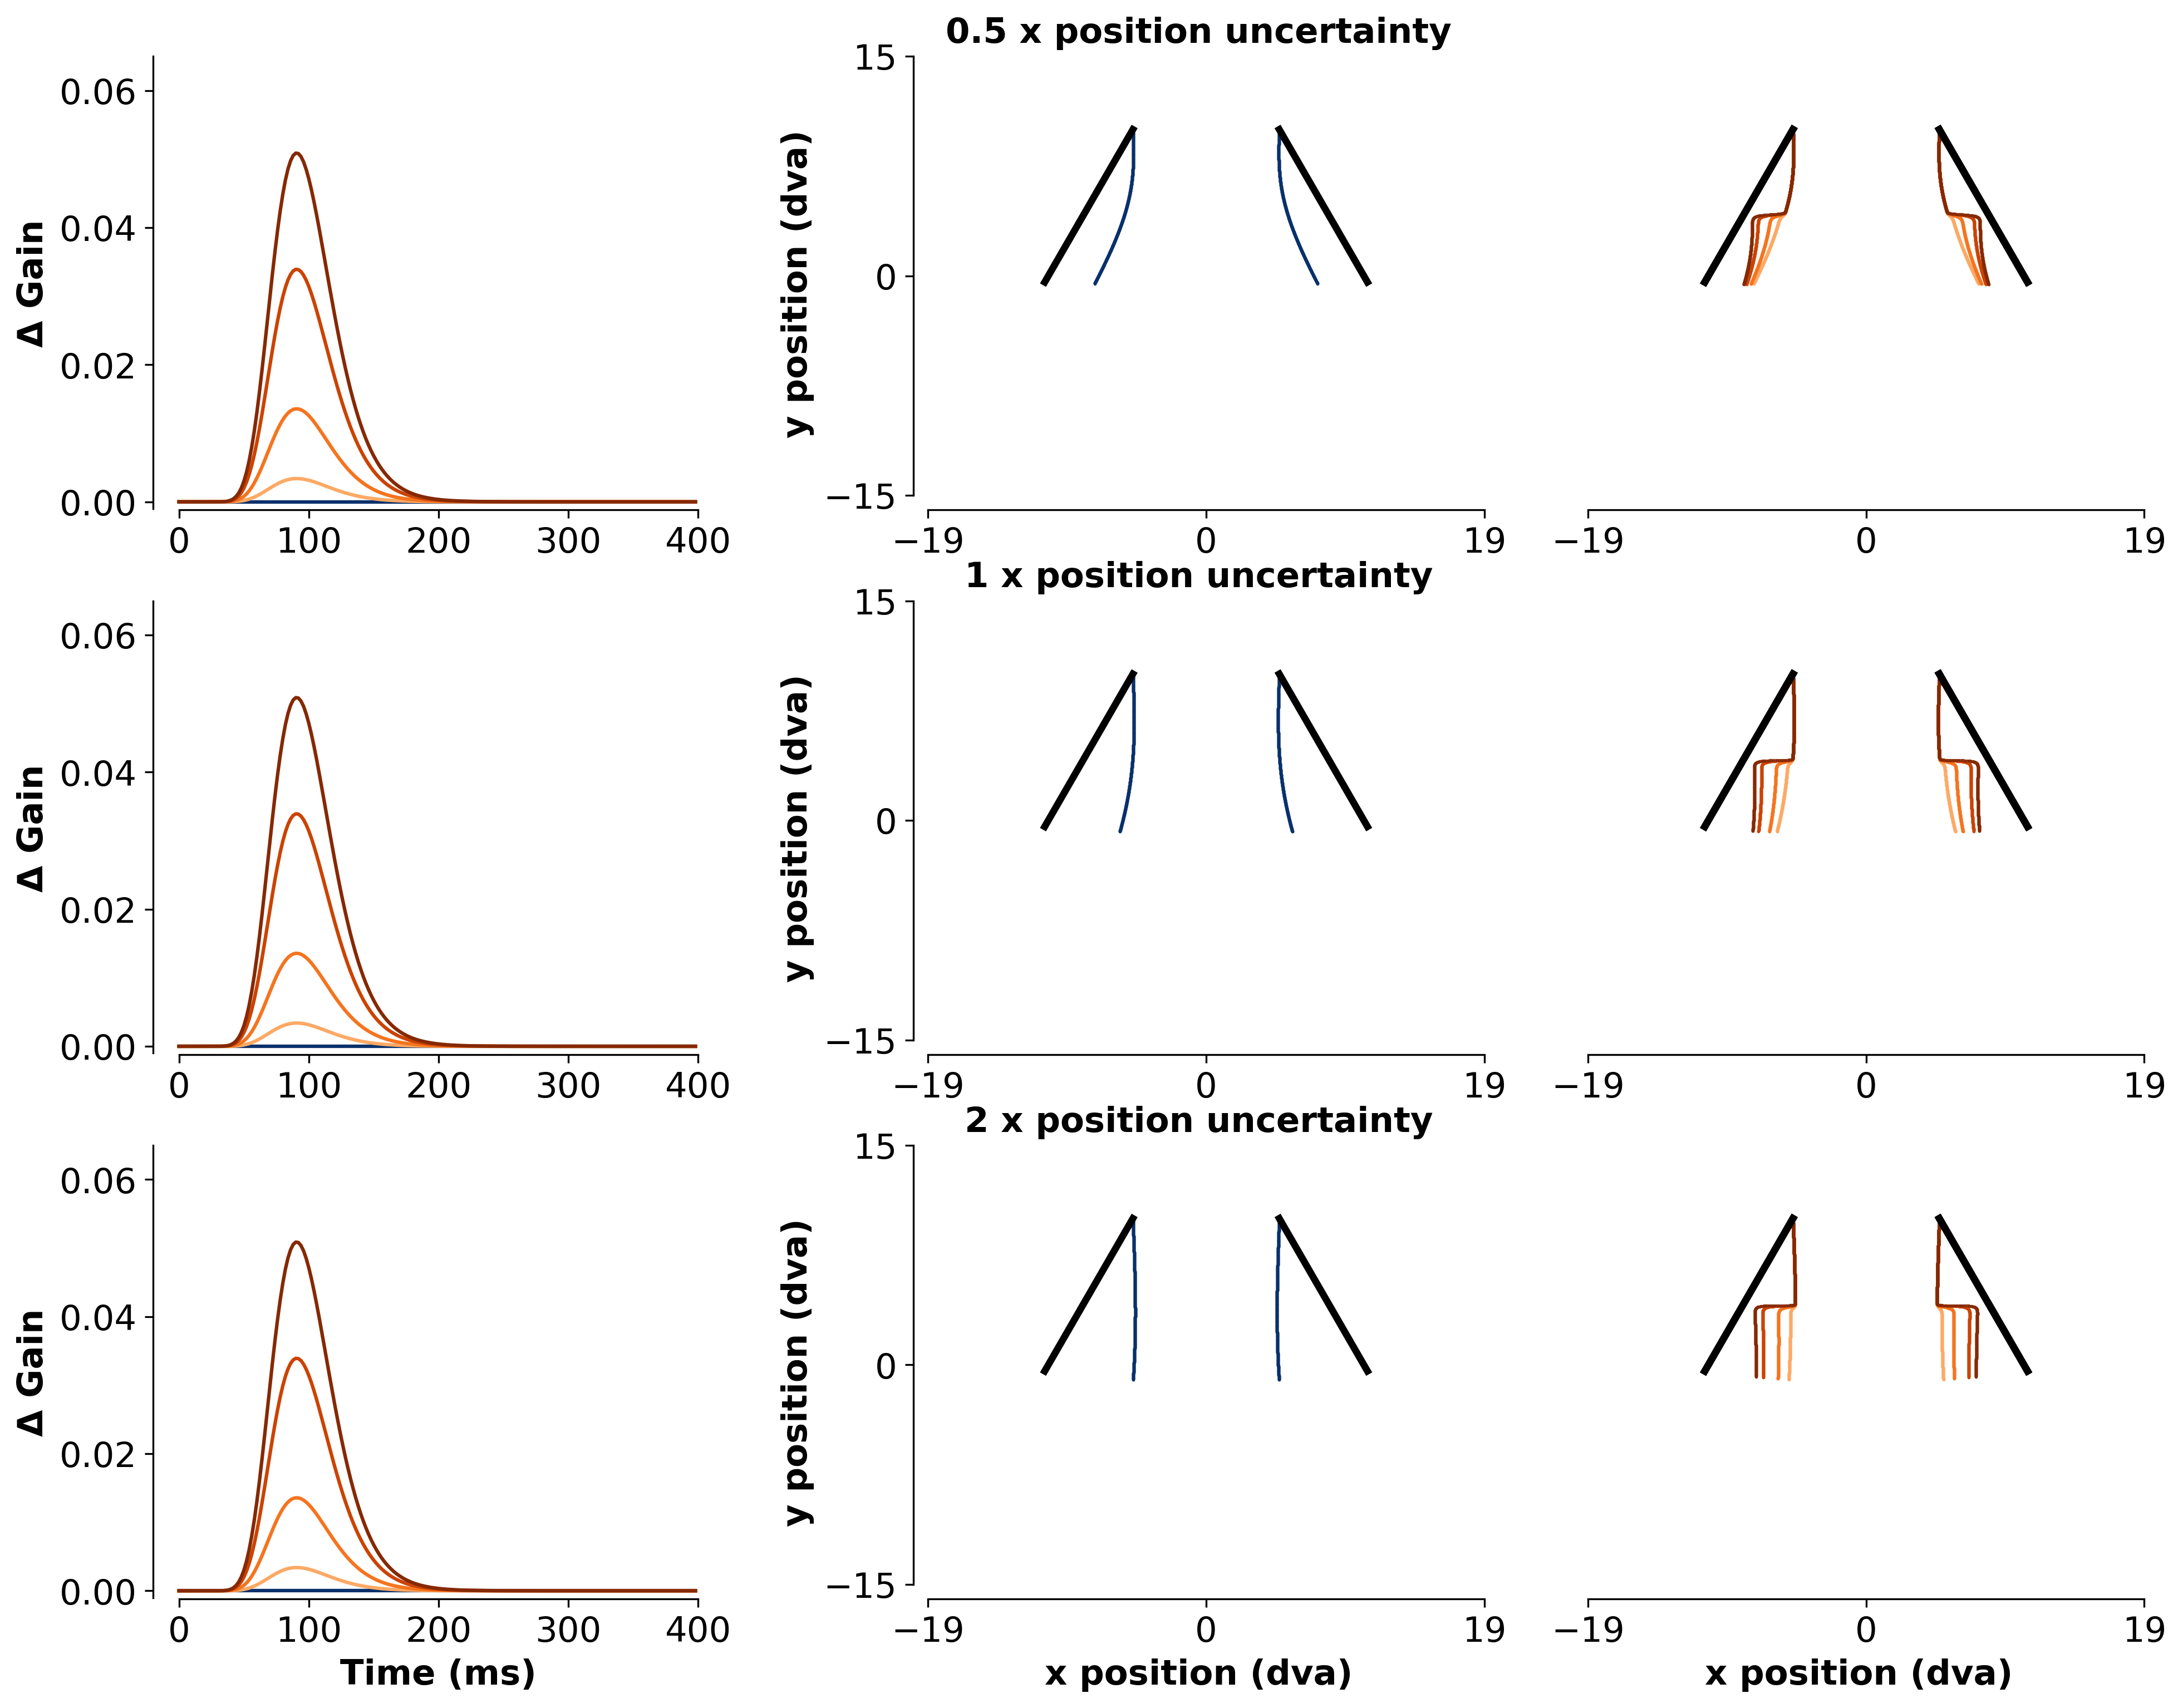

In [3]:
# simulate changes in position uncertainty

run_sim('position') # simulate modulation of position noise

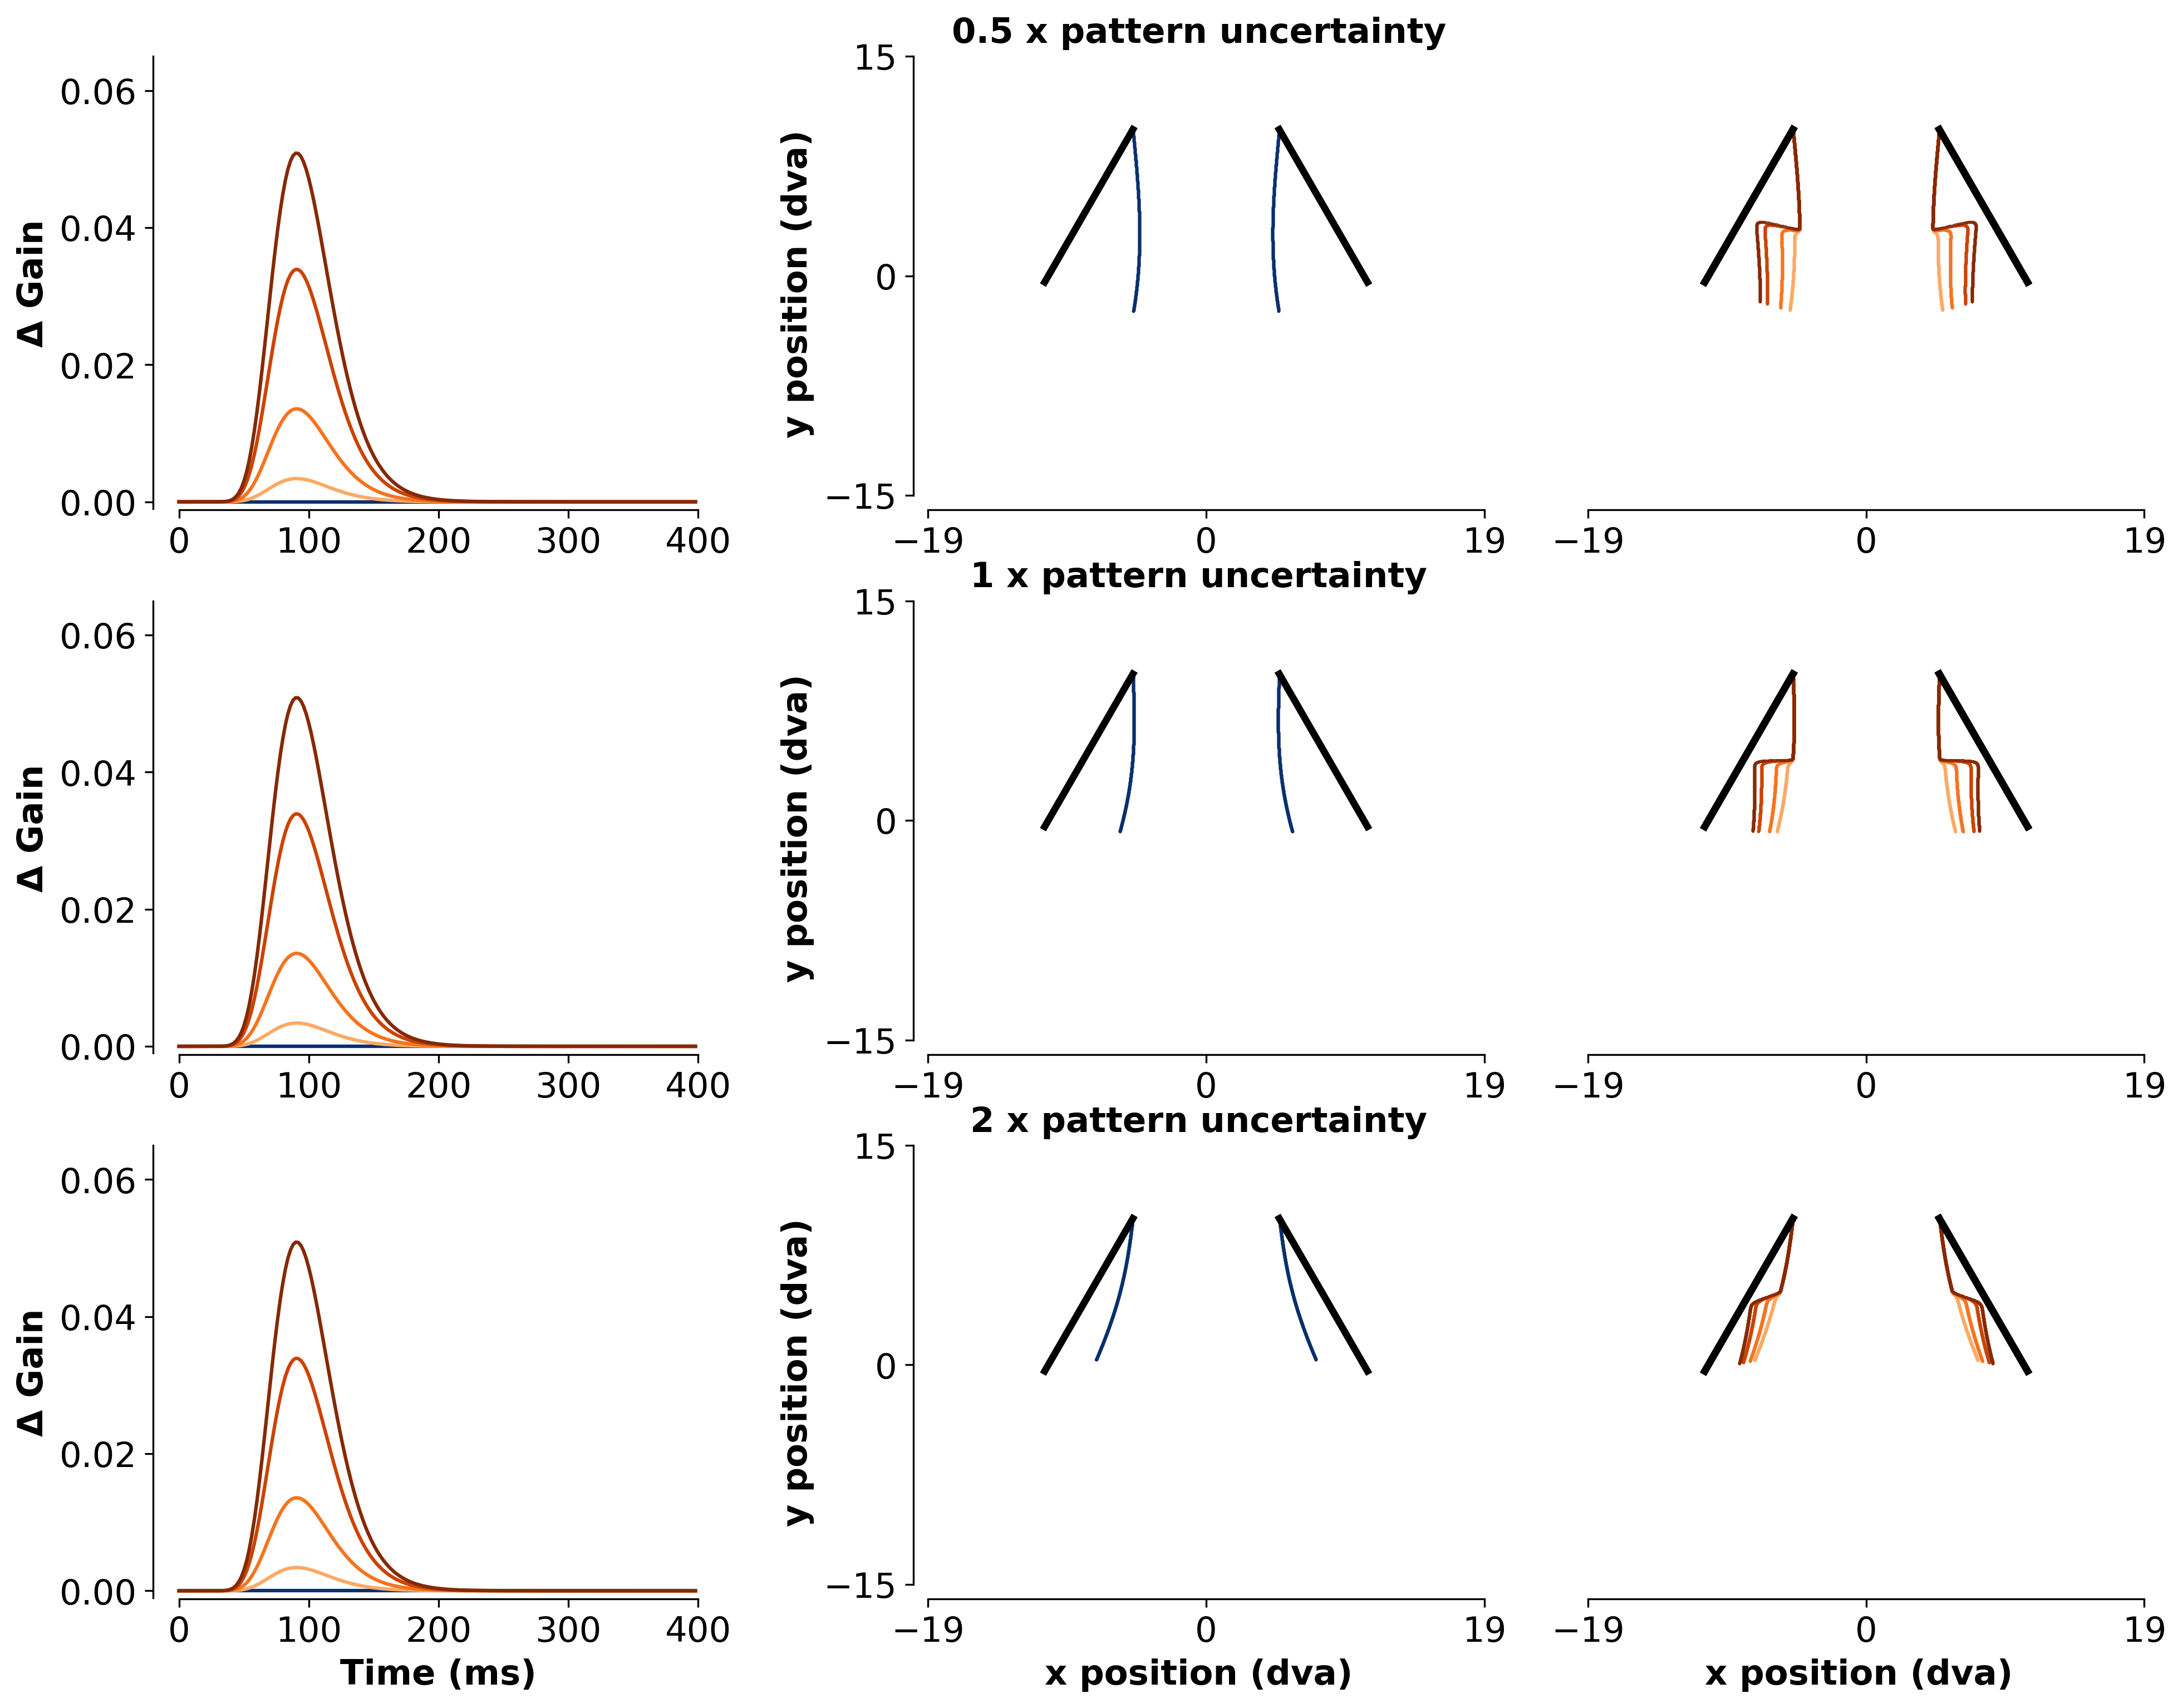

In [4]:
# simulate changes in pattern motion uncertainty

run_sim('pattern') # simulate modulation of pattern noise

## Observations 

Position resets can be observed across both manipulations. However, it's interesting to note that these manipulations have qualitatively different effects on the stimulus trajectories and abruptness of the resets. With increasing position uncertainty the overall double drift effect grows (the distance between the estimated and actual position of the stimulus grows) and the resets appear to be slightly more abrupt (sharper kinks in the trajectory). Conversely, *decreasing* pattern uncertainty leads to an increase the illusory effect and more abrupt resets. As such, the directional effect of sensory uncertainty on the illusion is not uniform and depends on the exact stimulus feature being targeted. 